In [49]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import zipfile

from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
if not os.path.exists('/content/cnn_dataset'):
    os.makedirs('/content/cnn_dataset')

with zipfile.ZipFile('/content/cnn_dataset.zip', 'r') as file:
    file.extractall('/content/cnn_dataset')

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
dataset = ImageFolder(root='/content/cnn_dataset', transform=transform)

In [5]:
mean, std = torch.zeros(3), torch.zeros(3)

for X, _ in dataset:
    mean += X.mean(dim=(1,2))
    std += X.std(dim=(1,2))

mean /= len(dataset)
std /= len(dataset)
mean, std

(tensor([0.5047, 0.4501, 0.3841]), tensor([0.2378, 0.2380, 0.2392]))

In [6]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [7]:
dataset = ImageFolder(root='/content/cnn_dataset', transform=transform)

print("Number of classes:", len(dataset.classes))
print("Type of classes:", len(dataset.classes))
print("Length of dataset", len(dataset))

Number of classes: 3
Type of classes: 3
Length of dataset 30000


In [8]:
batch_size = 128
train_set, test_set = train_test_split(dataset, test_size=0.15, random_state=42)
train_set, validation_set = train_test_split(train_set, test_size=0.2, random_state=42)

In [9]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [10]:
len(train_loader), len(validation_loader), len(test_loader)

(160, 40, 36)

In [11]:
len(train_loader.dataset), len(validation_loader.dataset), len(test_loader.dataset)

(20400, 5100, 4500)

In [12]:
def visualize_batch(image):
    image /= 2
    image = image + 0.5
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.show()

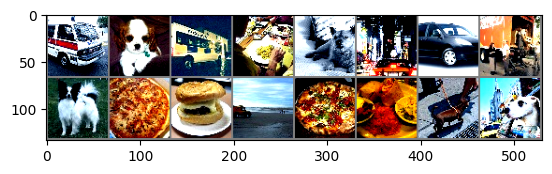

In [13]:
for X_train, y_train in train_loader:
    visualize_batch(torchvision.utils.make_grid(X_train[:16]))
    print(X_train[:1].shape)
    print("Labels:", y_train[:16], len(y_train))
    break

## **Vision Transformer**

In [14]:
class ViT(nn.Module):
    def __init__(self, image_shape, P, latent_dim, head, depth, mlp_dim):
        C, H, W = image_shape[0], image_shape[1], image_shape[2]
        super(ViT, self).__init__()
        if H % P != 0:
            assert False, 'Image should be completely represented by patches'
        N = (H * W) // (P) ** 2
        P_dim = C * P ** 2

        self.P_embedding = nn.Conv2d(in_channels=C, out_channels=latent_dim, kernel_size=P, stride=P)
        self.positional_embedding = nn.Parameter(torch.randn(1, N + 1, latent_dim))
        self.token = nn.Parameter(torch.randn(1, 1, latent_dim))
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=latent_dim, nhead=head, dim_feedforward=mlp_dim), num_layers=depth)
        self.fc = nn.Linear(latent_dim, 3)

    def forward(self, x):
        x = self.P_embedding(x).flatten(2).transpose(1, 2)
        tokens = self.token.expand(x.shape[0], -1, -1)
        x = torch.cat((tokens, x), dim=1)
        x = self.encoder(x + self.positional_embedding)[:, 0, :]
        x = self.fc(x)
        return x

torch.Size([1, 3, 64, 64])
Labels: tensor([2, 0, 2, 1, 0, 2, 2, 2, 0, 1, 1, 2, 1, 1, 0, 2]) 128


In [22]:
model = ViT(image_shape=(3, 64, 64), P=32, latent_dim=64, head=8, depth=12, mlp_dim=128)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
print(model)
print(summary(model, input_size=(128, 3, 64, 64)))

ViT(
  (P_embedding): Conv2d(3, 64, kernel_size=(32, 32), stride=(32, 32))
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=64, out_features=3, bias=True)
)
Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [128, 3]                  384
├─Conv2d

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [23]:
train_loss, validation_loss, test_loss = [], [], []
train_accuracy, validation_accuracy, test_accuracy = [], [], []
train_time, validation_time, test_time = [], [], []

# Train the model
num_epochs = 15
epochs_start_time = time.time()
for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]:')
    # On Train Data
    start_time = time.time()
    total_accuracy, total_loss = 0.0, 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, outputs = torch.max(outputs, 1)
        total_loss += loss.item()
        total_accuracy += int(torch.sum(labels == outputs))
    stop_time = time.time()
    train_time.append(stop_time-start_time)
    train_accuracy.append(total_accuracy/len(train_set))
    average_loss = total_loss/len(train_loader)
    train_loss.append(average_loss)
    print(f'\tTraining Loss: {average_loss}, Accuracy: {(total_accuracy/len(train_set))*100}, Time: {(stop_time-start_time)/60} mins')

    # On Validation Data
    model.eval()
    start_time = time.time()
    total_accuracy, total_loss = 0.0, 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, outputs = torch.max(outputs, 1)
            total_loss += loss.item()
            total_accuracy += int(torch.sum(labels == outputs))
    stop_time = time.time()
    validation_time.append(stop_time-start_time)
    validation_accuracy.append(total_accuracy/len(validation_set))
    average_loss = total_loss/len(validation_loader)
    validation_loss.append(average_loss)
    print(f'\tValidation Loss: {average_loss}, Accuracy: {(total_accuracy/len(validation_set))*100}, Time: {(stop_time-start_time)/60} mins')

    # On Test Data
    model.eval()
    total_accuracy, total_loss = 0.0, 0.0
    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, outputs = torch.max(outputs, 1)
            total_loss += loss.item()
            total_accuracy += int(torch.sum(labels == outputs))
    stop_time = time.time()
    test_time.append(stop_time-start_time)
    test_accuracy.append(total_accuracy/len(test_set))
    average_loss = total_loss/len(test_loader)
    test_loss.append(average_loss)
    print(f'\tTest Loss: {average_loss}, Accuracy: {(total_accuracy/len(test_set))*100}, Time: {(stop_time-start_time)/60} mins')

epochs_end_time = time.time()

print("="*70)
print(f'Total time taken = {(epochs_end_time-epochs_start_time)/60} mins')
print("Completed iterating over epochs")
print("="*70)

print("Losses: \n", train_loss, validation_loss, test_loss)
print("Accuracy: \n", train_accuracy, validation_accuracy, test_accuracy)

Epoch [1/15]:
	Training Loss: 1.1253002479672432, Accuracy: 33.205882352941174, Time: 0.07878223260243734 mins
	Validation Loss: 1.099676164984703, Accuracy: 33.98039215686274, Time: 0.006900386015574137 mins
	Test Loss: 1.1004595292939081, Accuracy: 33.111111111111114, Time: 0.006279170513153076 mins
Epoch [2/15]:
	Training Loss: 1.1027179293334484, Accuracy: 33.44607843137255, Time: 0.09861731131871541 mins
	Validation Loss: 1.0989041537046433, Accuracy: 32.745098039215684, Time: 0.00656737486521403 mins
	Test Loss: 1.0985954999923706, Accuracy: 33.53333333333333, Time: 0.005734435717264811 mins
Epoch [3/15]:
	Training Loss: 1.0997305765748024, Accuracy: 33.122549019607845, Time: 0.08926248550415039 mins
	Validation Loss: 1.0998276710510253, Accuracy: 33.27450980392157, Time: 0.014417827129364014 mins
	Test Loss: 1.0995599958631728, Accuracy: 33.355555555555554, Time: 0.019131275018056233 mins
Epoch [4/15]:
	Training Loss: 1.099560011923313, Accuracy: 33.02450980392157, Time: 0.15934

In [25]:
def plot_loss(train_loss, validation_loss, test_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_loss, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), validation_loss, label='Validation Loss')
    plt.plot(range(1, num_epochs + 1), test_loss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Losses')
    plt.legend()
    plt.grid()
    plt.show()

def plot_accuracy(train_acc, validation_acc, test_acc):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_acc, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), validation_acc, label='Validation Accuracy')
    plt.plot(range(1, num_epochs + 1), test_acc, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracies')
    plt.legend()
    plt.grid()
    plt.show()

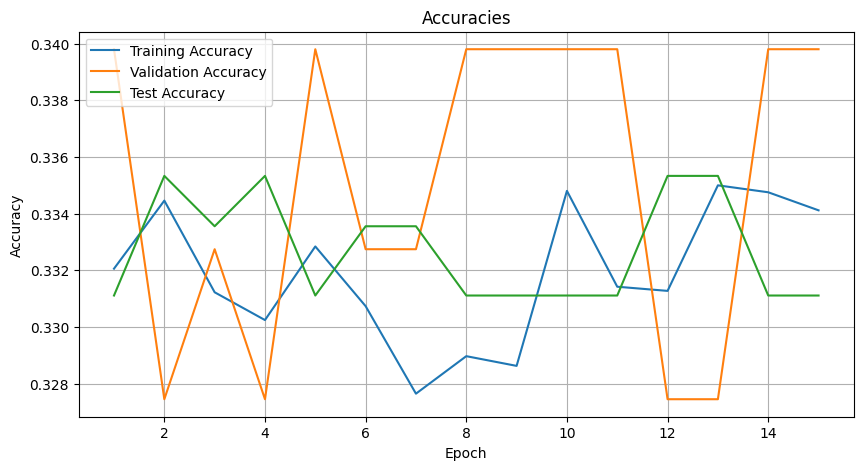

In [26]:
plot_accuracy(train_accuracy, validation_accuracy, test_accuracy)

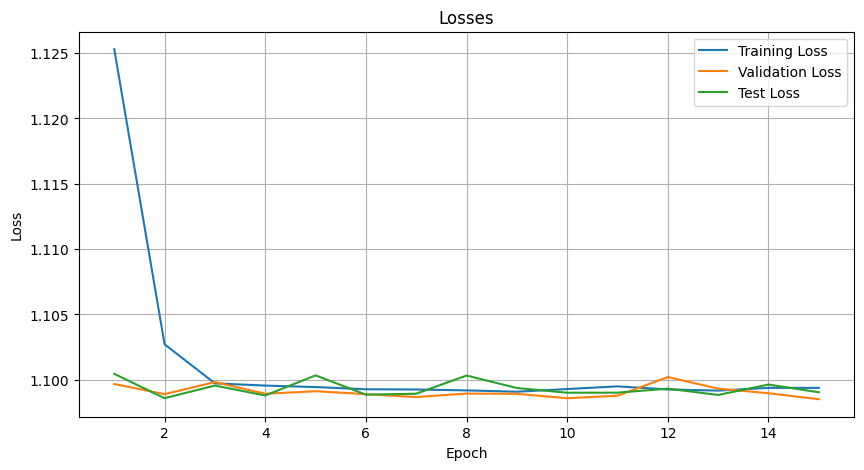

In [27]:
plot_loss(train_loss, validation_loss, test_loss)

## **VGG16 Model**

In [28]:
vgg_model = torchvision.models.vgg16(pretrained=False)
vgg_model.classifier[6] = nn.Linear(4096, 3)
vgg_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [29]:
train_loss, validation_loss, test_loss = [], [], []
train_accuracy, validation_accuracy, test_accuracy = [], [], []
train_time, validation_time, test_time = [], [], []

# Train the model
num_epochs = 5
epochs_start_time = time.time()
for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]:')
    # On Train Data
    start_time = time.time()
    total_accuracy, total_loss = 0.0, 0.0
    vgg_model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = vgg_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, outputs = torch.max(outputs, 1)
        total_loss += loss.item()
        total_accuracy += int(torch.sum(labels == outputs))
    stop_time = time.time()
    train_time.append(stop_time-start_time)
    train_accuracy.append(total_accuracy/len(train_set))
    average_loss = total_loss/len(train_loader)
    train_loss.append(average_loss)
    print(f'\tTraining Loss: {average_loss}, Accuracy: {(total_accuracy/len(train_set))*100}, Time: {(stop_time-start_time)/60} mins')

    # On Validation Data
    vgg_model.eval()
    start_time = time.time()
    total_accuracy, total_loss = 0.0, 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = vgg_model(inputs)
            loss = criterion(outputs, labels)
            _, outputs = torch.max(outputs, 1)
            total_loss += loss.item()
            total_accuracy += int(torch.sum(labels == outputs))
    stop_time = time.time()
    validation_time.append(stop_time-start_time)
    validation_accuracy.append(total_accuracy/len(validation_set))
    average_loss = total_loss/len(validation_loader)
    validation_loss.append(average_loss)
    print(f'\tValidation Loss: {average_loss}, Accuracy: {(total_accuracy/len(validation_set))*100}, Time: {(stop_time-start_time)/60} mins')

    # On Test Data
    vgg_model.eval()
    total_accuracy, total_loss = 0.0, 0.0
    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = vgg_model(inputs)
            loss = criterion(outputs, labels)
            _, outputs = torch.max(outputs, 1)
            total_loss += loss.item()
            total_accuracy += int(torch.sum(labels == outputs))
    stop_time = time.time()
    test_time.append(stop_time-start_time)
    test_accuracy.append(total_accuracy/len(test_set))
    average_loss = total_loss/len(test_loader)
    test_loss.append(average_loss)
    print(f'\tTest Loss: {average_loss}, Accuracy: {(total_accuracy/len(test_set))*100}, Time: {(stop_time-start_time)/60} mins')

epochs_end_time = time.time()

print("="*70)
print(f'Total time taken = {(epochs_end_time-epochs_start_time)/60} mins')
print("Completed iterating over epochs")
print("="*70)

print("Losses: \n", train_loss, validation_loss, test_loss)
print("Accuracy: \n", train_accuracy, validation_accuracy, test_accuracy)

Epoch [1/5]:
	Training Loss: 0.9273084163665771, Accuracy: 53.98529411764705, Time: 0.5235071857770284 mins
	Validation Loss: 0.6977361410856247, Accuracy: 68.6078431372549, Time: 0.045775727430979414 mins
	Test Loss: 0.6887394107050366, Accuracy: 69.06666666666666, Time: 0.0398881991704305 mins
Epoch [2/5]:
	Training Loss: 0.6010584980249405, Accuracy: 75.04901960784314, Time: 0.510170829296112 mins
	Validation Loss: 0.43999068364501, Accuracy: 81.86274509803921, Time: 0.042399144172668456 mins
	Test Loss: 0.42999425447649425, Accuracy: 82.64444444444445, Time: 0.0371053417523702 mins
Epoch [3/5]:
	Training Loss: 0.4736313045024872, Accuracy: 81.48529411764706, Time: 0.5116262475649516 mins
	Validation Loss: 0.42480832859873774, Accuracy: 83.66666666666667, Time: 0.043764630953470864 mins
	Test Loss: 0.41677455107371014, Accuracy: 84.17777777777778, Time: 0.03877401351928711 mins
Epoch [4/5]:
	Training Loss: 0.39943980518728495, Accuracy: 84.62745098039215, Time: 0.515058437983195 min

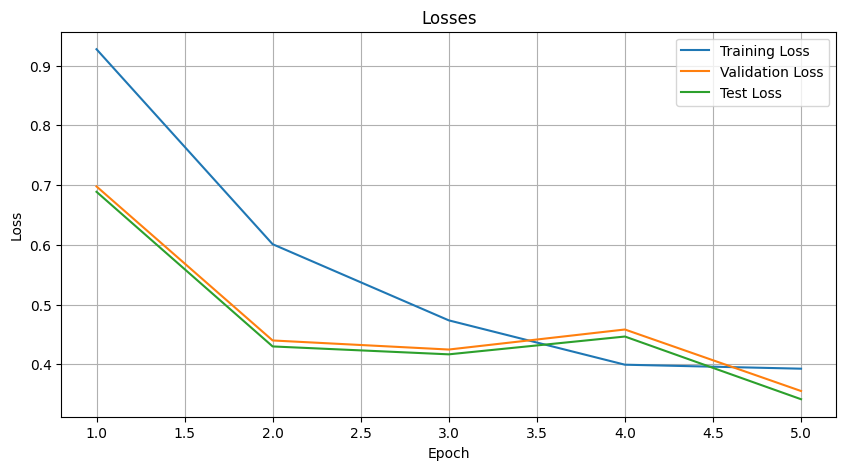

In [30]:
plot_loss(train_loss, validation_loss, test_loss)

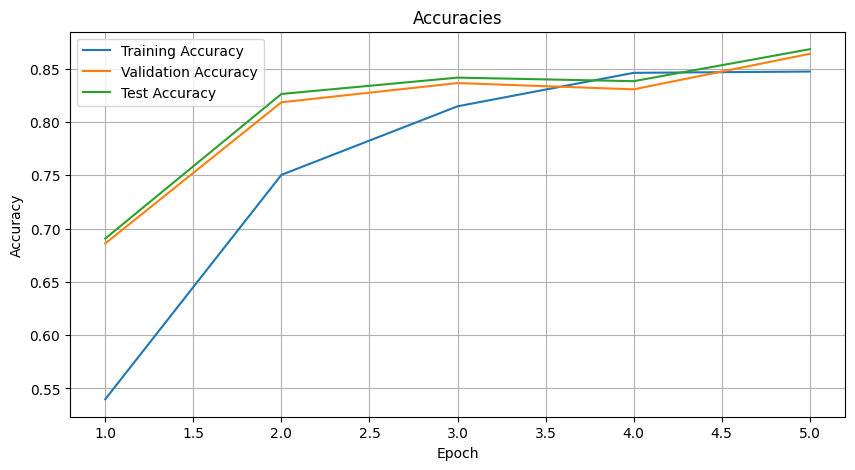

In [31]:
plot_accuracy(train_accuracy, validation_accuracy, test_accuracy)

## **ResNet Model**

In [32]:
resnet_model = torchvision.models.resnet18(pretrained=False)
resnet_model.fc = nn.Linear(512, 3)
resnet_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9)

In [33]:
train_loss, validation_loss, test_loss = [], [], []
train_accuracy, validation_accuracy, test_accuracy = [], [], []
train_time, validation_time, test_time = [], [], []

# Train the model
num_epochs = 5
epochs_start_time = time.time()
for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]:')
    # On Train Data
    start_time = time.time()
    total_accuracy, total_loss = 0.0, 0.0
    resnet_model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, outputs = torch.max(outputs, 1)
        total_loss += loss.item()
        total_accuracy += int(torch.sum(labels == outputs))
    stop_time = time.time()
    train_time.append(stop_time-start_time)
    train_accuracy.append(total_accuracy/len(train_set))
    average_loss = total_loss/len(train_loader)
    train_loss.append(average_loss)
    print(f'\tTraining Loss: {average_loss}, Accuracy: {(total_accuracy/len(train_set))*100}, Time: {(stop_time-start_time)/60} mins')

    # On Validation Data
    resnet_model.eval()
    start_time = time.time()
    total_accuracy, total_loss = 0.0, 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = resnet_model(inputs)
            loss = criterion(outputs, labels)
            _, outputs = torch.max(outputs, 1)
            total_loss += loss.item()
            total_accuracy += int(torch.sum(labels == outputs))
    stop_time = time.time()
    validation_time.append(stop_time-start_time)
    validation_accuracy.append(total_accuracy/len(validation_set))
    average_loss = total_loss/len(validation_loader)
    validation_loss.append(average_loss)
    print(f'\tValidation Loss: {average_loss}, Accuracy: {(total_accuracy/len(validation_set))*100}, Time: {(stop_time-start_time)/60} mins')

    # On Test Data
    resnet_model.eval()
    total_accuracy, total_loss = 0.0, 0.0
    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = resnet_model(inputs)
            loss = criterion(outputs, labels)
            _, outputs = torch.max(outputs, 1)
            total_loss += loss.item()
            total_accuracy += int(torch.sum(labels == outputs))
    stop_time = time.time()
    test_time.append(stop_time-start_time)
    test_accuracy.append(total_accuracy/len(test_set))
    average_loss = total_loss/len(test_loader)
    test_loss.append(average_loss)
    print(f'\tTest Loss: {average_loss}, Accuracy: {(total_accuracy/len(test_set))*100}, Time: {(stop_time-start_time)/60} mins')

epochs_end_time = time.time()

print("="*70)
print(f'Total time taken = {(epochs_end_time-epochs_start_time)/60} mins')
print("Completed iterating over epochs")
print("="*70)

print("Losses: \n", train_loss, validation_loss, test_loss)
print("Accuracy: \n", train_accuracy, validation_accuracy, test_accuracy)

Epoch [1/5]:
	Training Loss: 0.6565889459103346, Accuracy: 71.54901960784314, Time: 0.14257960716883342 mins
	Validation Loss: 0.4745727092027664, Accuracy: 80.84313725490196, Time: 0.009210769335428875 mins
	Test Loss: 0.4742519300844934, Accuracy: 81.28888888888889, Time: 0.00851979653040568 mins
Epoch [2/5]:
	Training Loss: 0.40695391967892647, Accuracy: 83.77941176470588, Time: 0.1506992260615031 mins
	Validation Loss: 0.370073377341032, Accuracy: 85.54901960784314, Time: 0.014500896135965982 mins
	Test Loss: 0.3776760929160648, Accuracy: 86.0, Time: 0.008515238761901855 mins
Epoch [3/5]:
	Training Loss: 0.3280405024066567, Accuracy: 87.5392156862745, Time: 0.14350179433822632 mins
	Validation Loss: 0.3453867670148611, Accuracy: 86.50980392156863, Time: 0.009225920836130778 mins
	Test Loss: 0.33456024651726085, Accuracy: 87.4888888888889, Time: 0.00794285535812378 mins
Epoch [4/5]:
	Training Loss: 0.2740955542773008, Accuracy: 89.75, Time: 0.1449014147122701 mins
	Validation Loss: 

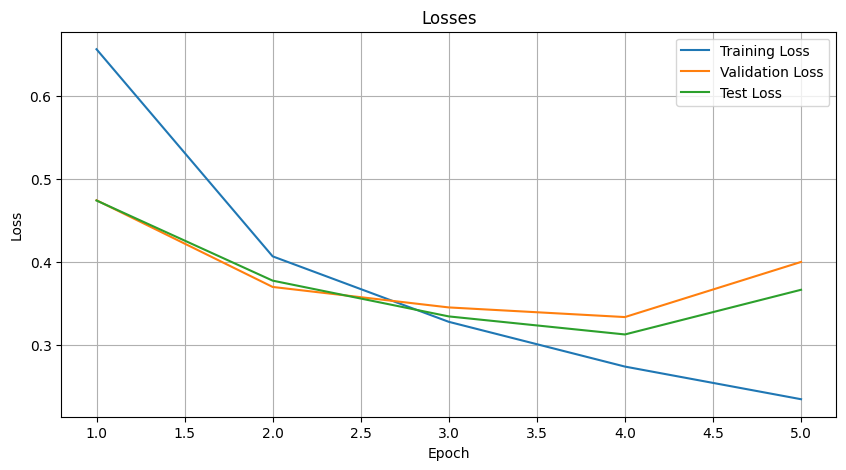

In [34]:
plot_loss(train_loss, validation_loss, test_loss)

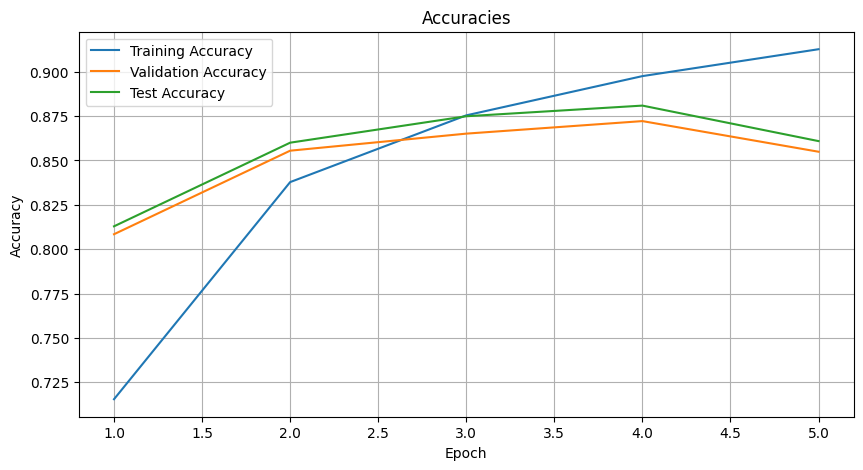

In [35]:
plot_accuracy(train_accuracy, validation_accuracy, test_accuracy)

# **EfficientNet**

In [53]:
efficientnet_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=3)
efficientnet_model.to(device)

print(efficientnet_model)

Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kern

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001)

In [55]:
train_loss, validation_loss, test_loss = [], [], []
train_accuracy, validation_accuracy, test_accuracy = [], [], []
train_time, validation_time, test_time = [], [], []

# Train the model
num_epochs = 5
epochs_start_time = time.time()
for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]:')
    # On Train Data
    start_time = time.time()
    total_accuracy, total_loss = 0.0, 0.0
    efficientnet_model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = efficientnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, outputs = torch.max(outputs, 1)
        total_loss += loss.item()
        total_accuracy += int(torch.sum(labels == outputs))
    stop_time = time.time()
    train_time.append(stop_time-start_time)
    train_accuracy.append(total_accuracy/len(train_set))
    average_loss = total_loss/len(train_loader)
    train_loss.append(average_loss)
    print(f'\tTraining Loss: {average_loss}, Accuracy: {(total_accuracy/len(train_set))*100}, Time: {(stop_time-start_time)/60} mins')

    # On Validation Data
    efficientnet_model.eval()
    start_time = time.time()
    total_accuracy, total_loss = 0.0, 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = efficientnet_model(inputs)
            loss = criterion(outputs, labels)
            _, outputs = torch.max(outputs, 1)
            total_loss += loss.item()
            total_accuracy += int(torch.sum(labels == outputs))
    stop_time = time.time()
    validation_time.append(stop_time-start_time)
    validation_accuracy.append(total_accuracy/len(validation_set))
    average_loss = total_loss/len(validation_loader)
    validation_loss.append(average_loss)
    print(f'\tValidation Loss: {average_loss}, Accuracy: {(total_accuracy/len(validation_set))*100}, Time: {(stop_time-start_time)/60} mins')

    # On Test Data
    efficientnet_model.eval()
    total_accuracy, total_loss = 0.0, 0.0
    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = efficientnet_model(inputs)
            loss = criterion(outputs, labels)
            _, outputs = torch.max(outputs, 1)
            total_loss += loss.item()
            total_accuracy += int(torch.sum(labels == outputs))
    stop_time = time.time()
    test_time.append(stop_time-start_time)
    test_accuracy.append(total_accuracy/len(test_set))
    average_loss = total_loss/len(test_loader)
    test_loss.append(average_loss)
    print(f'\tTest Loss: {average_loss}, Accuracy: {(total_accuracy/len(test_set))*100}, Time: {(stop_time-start_time)/60} mins')

epochs_end_time = time.time()

print("="*70)
print(f'Total time taken = {(epochs_end_time-epochs_start_time)/60} mins')
print("Completed iterating over epochs")
print("="*70)

print("Losses: \n", train_loss, validation_loss, test_loss)
print("Accuracy: \n", train_accuracy, validation_accuracy, test_accuracy)

Epoch [1/5]:
	Training Loss: 0.1597470538923517, Accuracy: 94.30392156862744, Time: 0.27127769390741985 mins
	Validation Loss: 0.08669170322827995, Accuracy: 97.01960784313725, Time: 0.020660400390625 mins
	Test Loss: 0.0907813400004266, Accuracy: 97.02222222222223, Time: 0.018473327159881592 mins
Epoch [2/5]:
	Training Loss: 0.06299236789927817, Accuracy: 97.84803921568627, Time: 0.2750840743382772 mins
	Validation Loss: 0.10423843774478883, Accuracy: 97.11764705882354, Time: 0.02046757936477661 mins
	Test Loss: 0.09050009720441368, Accuracy: 97.44444444444444, Time: 0.01819240649541219 mins
Epoch [3/5]:
	Training Loss: 0.04491443826118484, Accuracy: 98.52450980392156, Time: 0.2715712030728658 mins
	Validation Loss: 0.10985031498130411, Accuracy: 96.92156862745098, Time: 0.020462210973103842 mins
	Test Loss: 0.08833544558082293, Accuracy: 97.24444444444444, Time: 0.01792323589324951 mins
Epoch [4/5]:
	Training Loss: 0.030750335095217452, Accuracy: 98.93627450980392, Time: 0.2699110031

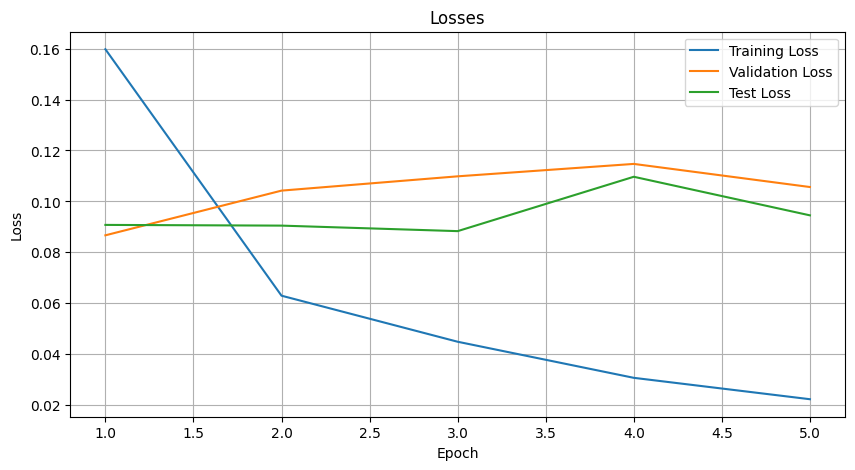

In [56]:
plot_loss(train_loss, validation_loss, test_loss)

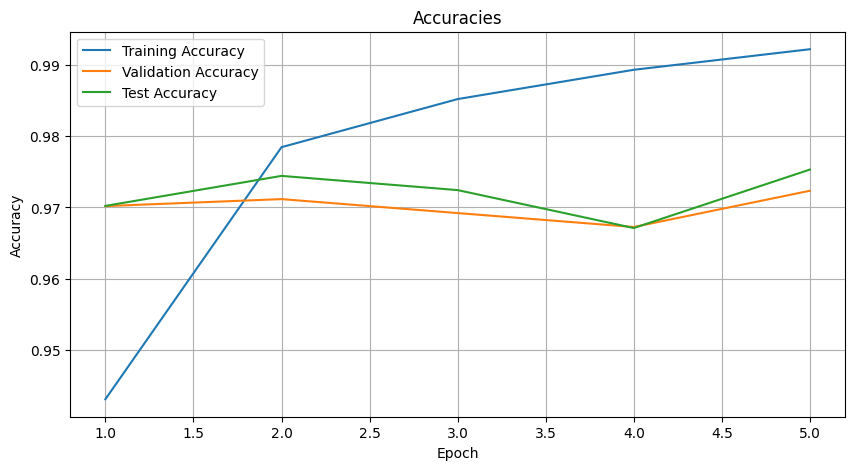

In [57]:
plot_accuracy(train_accuracy, validation_accuracy, test_accuracy)

## **VGG16 Model**

In [41]:
vgg_model = models.vgg16(pretrained=True)
num_ftrs = vgg_model.classifier[6].in_features
vgg_model.classifier[6] = nn.Linear(num_ftrs, 3)
vgg_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 76.8MB/s]


In [42]:
train_loss, validation_loss, test_loss = [], [], []
train_accuracy, validation_accuracy, test_accuracy = [], [], []
train_time, validation_time, test_time = [], [], []

# Train the model
num_epochs = 10
epochs_start_time = time.time()
for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]:')
    # On Train Data
    start_time = time.time()
    total_accuracy, total_loss = 0.0, 0.0
    vgg_model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = vgg_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, outputs = torch.max(outputs, 1)
        total_loss += loss.item()
        total_accuracy += int(torch.sum(labels == outputs))
    stop_time = time.time()
    train_time.append(stop_time-start_time)
    train_accuracy.append(total_accuracy/len(train_set))
    average_loss = total_loss/len(train_loader)
    train_loss.append(average_loss)
    print(f'\tTraining Loss: {average_loss}, Accuracy: {(total_accuracy/len(train_set))*100}, Time: {(stop_time-start_time)/60} mins')

    # On Validation Data
    vgg_model.eval()
    start_time = time.time()
    total_accuracy, total_loss = 0.0, 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = vgg_model(inputs)
            loss = criterion(outputs, labels)
            _, outputs = torch.max(outputs, 1)
            total_loss += loss.item()
            total_accuracy += int(torch.sum(labels == outputs))
    stop_time = time.time()
    validation_time.append(stop_time-start_time)
    validation_accuracy.append(total_accuracy/len(validation_set))
    average_loss = total_loss/len(validation_loader)
    validation_loss.append(average_loss)
    print(f'\tValidation Loss: {average_loss}, Accuracy: {(total_accuracy/len(validation_set))*100}, Time: {(stop_time-start_time)/60} mins')

    # On Test Data
    vgg_model.eval()
    total_accuracy, total_loss = 0.0, 0.0
    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = vgg_model(inputs)
            loss = criterion(outputs, labels)
            _, outputs = torch.max(outputs, 1)
            total_loss += loss.item()
            total_accuracy += int(torch.sum(labels == outputs))
    stop_time = time.time()
    test_time.append(stop_time-start_time)
    test_accuracy.append(total_accuracy/len(test_set))
    average_loss = total_loss/len(test_loader)
    test_loss.append(average_loss)
    print(f'\tTest Loss: {average_loss}, Accuracy: {(total_accuracy/len(test_set))*100}, Time: {(stop_time-start_time)/60} mins')

epochs_end_time = time.time()

print("="*70)
print(f'Total time taken = {(epochs_end_time-epochs_start_time)/60} mins')
print("Completed iterating over epochs")
print("="*70)

print("Losses: \n", train_loss, validation_loss, test_loss)
print("Accuracy: \n", train_accuracy, validation_accuracy, test_accuracy)

Epoch [1/10]:
	Training Loss: 0.11135277192806825, Accuracy: 96.07843137254902, Time: 0.5065352439880371 mins
	Validation Loss: 0.04857629002071917, Accuracy: 98.37254901960785, Time: 0.04530150492986043 mins
	Test Loss: 0.050716830637409456, Accuracy: 98.31111111111112, Time: 0.04015027681986491 mins
Epoch [2/10]:
	Training Loss: 0.03972888730131672, Accuracy: 98.61274509803921, Time: 0.5246240973472596 mins
	Validation Loss: 0.05114405761705711, Accuracy: 98.29411764705883, Time: 0.0437552014986674 mins
	Test Loss: 0.04984123971209758, Accuracy: 98.31111111111112, Time: 0.03786683479944865 mins
Epoch [3/10]:
	Training Loss: 0.023439787206007166, Accuracy: 99.23039215686275, Time: 0.5067452510197957 mins
	Validation Loss: 0.043033387238392604, Accuracy: 98.5686274509804, Time: 0.04319480260213216 mins
	Test Loss: 0.046407099758248985, Accuracy: 98.55555555555556, Time: 0.038327197233835854 mins
Epoch [4/10]:
	Training Loss: 0.014518427249640808, Accuracy: 99.50980392156863, Time: 0.50

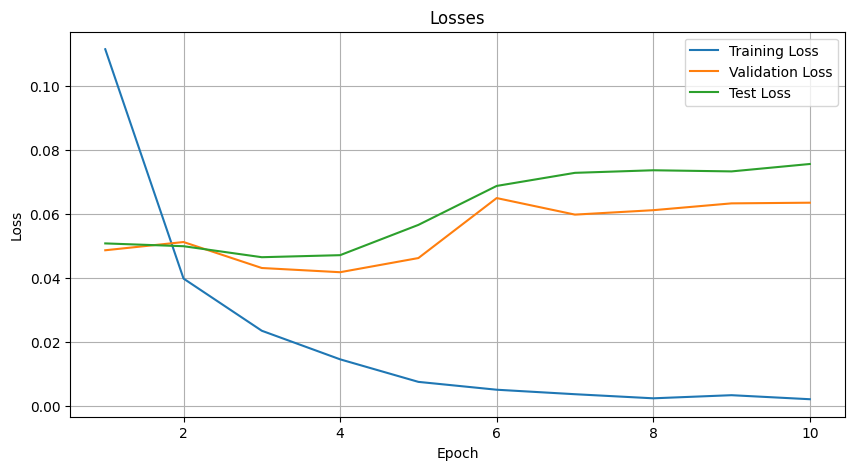

In [44]:
plot_loss(train_loss, validation_loss, test_loss)

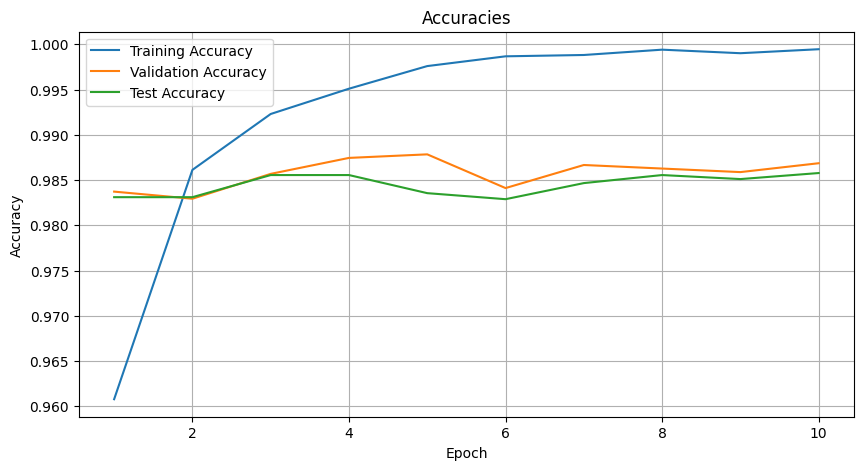

In [45]:
plot_accuracy(train_accuracy, validation_accuracy, test_accuracy)

## **ResNet Model**

In [58]:
resnet_model = models.resnet18(pretrained=True)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 3)
resnet_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [59]:
train_loss, validation_loss, test_loss = [], [], []
train_accuracy, validation_accuracy, test_accuracy = [], [], []
train_time, validation_time, test_time = [], [], []

# Train the model
num_epochs = 5
epochs_start_time = time.time()
for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]:')
    # On Train Data
    start_time = time.time()
    total_accuracy, total_loss = 0.0, 0.0
    resnet_model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, outputs = torch.max(outputs, 1)
        total_loss += loss.item()
        total_accuracy += int(torch.sum(labels == outputs))
    stop_time = time.time()
    train_time.append(stop_time-start_time)
    train_accuracy.append(total_accuracy/len(train_set))
    average_loss = total_loss/len(train_loader)
    train_loss.append(average_loss)
    print(f'\tTraining Loss: {average_loss}, Accuracy: {(total_accuracy/len(train_set))*100}, Time: {(stop_time-start_time)/60} mins')

    # On Validation Data
    resnet_model.eval()
    start_time = time.time()
    total_accuracy, total_loss = 0.0, 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = resnet_model(inputs)
            loss = criterion(outputs, labels)
            _, outputs = torch.max(outputs, 1)
            total_loss += loss.item()
            total_accuracy += int(torch.sum(labels == outputs))
    stop_time = time.time()
    validation_time.append(stop_time-start_time)
    validation_accuracy.append(total_accuracy/len(validation_set))
    average_loss = total_loss/len(validation_loader)
    validation_loss.append(average_loss)
    print(f'\tValidation Loss: {average_loss}, Accuracy: {(total_accuracy/len(validation_set))*100}, Time: {(stop_time-start_time)/60} mins')

    # On Test Data
    resnet_model.eval()
    total_accuracy, total_loss = 0.0, 0.0
    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = resnet_model(inputs)
            loss = criterion(outputs, labels)
            _, outputs = torch.max(outputs, 1)
            total_loss += loss.item()
            total_accuracy += int(torch.sum(labels == outputs))
    stop_time = time.time()
    test_time.append(stop_time-start_time)
    test_accuracy.append(total_accuracy/len(test_set))
    average_loss = total_loss/len(test_loader)
    test_loss.append(average_loss)
    print(f'\tTest Loss: {average_loss}, Accuracy: {(total_accuracy/len(test_set))*100}, Time: {(stop_time-start_time)/60} mins')

epochs_end_time = time.time()

print("="*70)
print(f'Total time taken = {(epochs_end_time-epochs_start_time)/60} mins')
print("Completed iterating over epochs")
print("="*70)

print("Losses: \n", train_loss, validation_loss, test_loss)
print("Accuracy: \n", train_accuracy, validation_accuracy, test_accuracy)

Epoch [1/5]:
	Training Loss: 0.2828854715451598, Accuracy: 88.92156862745098, Time: 0.1362286408742269 mins
	Validation Loss: 0.1423344498500228, Accuracy: 94.94117647058825, Time: 0.008761096000671386 mins
	Test Loss: 0.13868684766607153, Accuracy: 95.02222222222223, Time: 0.00781558354695638 mins
Epoch [2/5]:
	Training Loss: 0.0983269814401865, Accuracy: 96.58823529411765, Time: 0.13669806321461994 mins
	Validation Loss: 0.12035601809620858, Accuracy: 95.62745098039215, Time: 0.008815964063008627 mins
	Test Loss: 0.11619492258048719, Accuracy: 96.0, Time: 0.007817220687866212 mins
Epoch [3/5]:
	Training Loss: 0.05990009480447043, Accuracy: 97.94117647058823, Time: 0.14082088470458984 mins
	Validation Loss: 0.11281918934546412, Accuracy: 96.01960784313725, Time: 0.009081308046976726 mins
	Test Loss: 0.10768577275383803, Accuracy: 96.28888888888889, Time: 0.008069920539855956 mins
Epoch [4/5]:
	Training Loss: 0.03848024614271708, Accuracy: 98.86274509803921, Time: 0.1401094595591227 mi

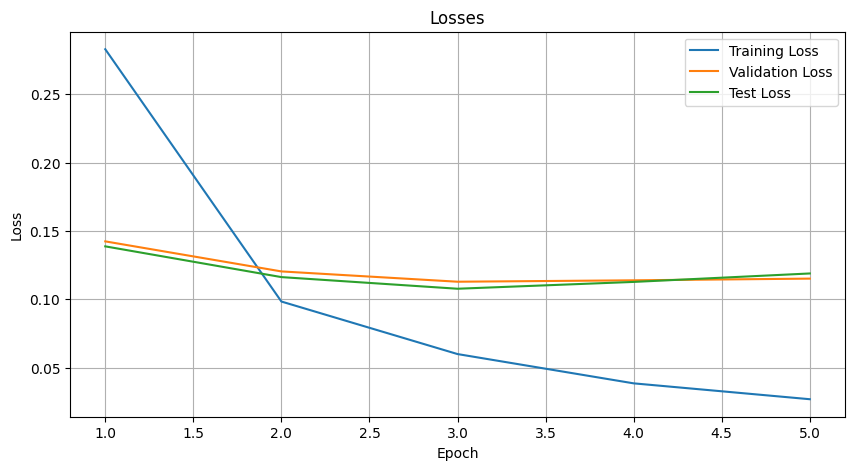

In [60]:
plot_loss(train_loss, validation_loss, test_loss)

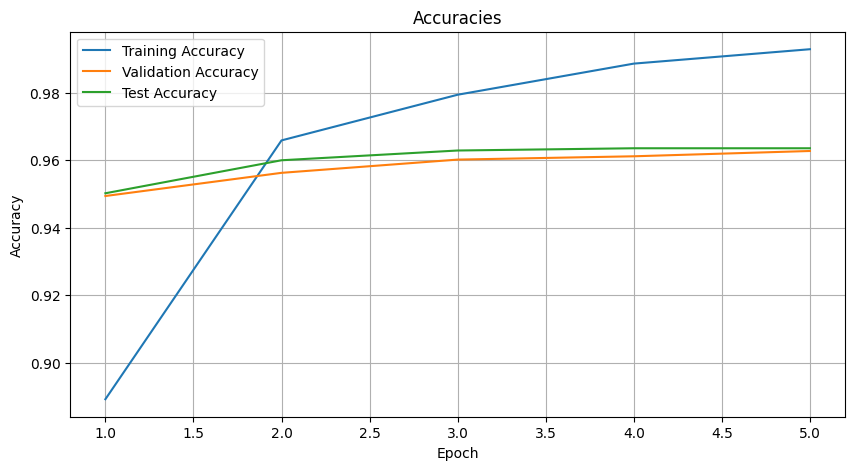

In [61]:
plot_accuracy(train_accuracy, validation_accuracy, test_accuracy)